# **Comparison between the original and optimized Hotspot versions**

In [1]:
import harreman
import os
import json
import numpy as np
import pandas as pd
import scanpy as sc
import muon as mu
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt
import mplscience
import matplotlib
import matplotlib as mpl
import matplotlib.colors
import itertools
from scipy.stats import pearsonr, spearmanr, gaussian_kde
import scipy.stats as stats
import random
from scipy.stats import hypergeom
from statsmodels.stats.multitest import multipletests
from scipy.io import mmread
from scipy.sparse import csr_matrix
from sklearn import linear_model
import pickle
from plotnine import *
import warnings
warnings.filterwarnings("ignore")


BASE_PATH = '/home/projects/nyosef/oier/Harreman_files/Hotspot_tutorial_analysis'
DATA_PATH = os.path.join(BASE_PATH, 'data')
ADATA_PATH = os.path.join(BASE_PATH, 'h5ads')
PLOTS_PATH = os.path.join(BASE_PATH, 'plots')

HOTSPOT_TUTO_DATA = '/home/projects/nyosef/oier/Hotspot_tutorial_data'

## Functions

In [2]:
def corr_plot(x, y, mean_expr, max_num=10000, outlier=0.01, line_on=True, method='spearman',
              legend_on=True, size=30, dot_color=None, outlier_color="r",
              alpha=0.8, color_rate=10, corr_on=None, colorbar=True, pmax=95, pmin=5):

    if method == 'pearson':
        score = pearsonr(x, y)
    if method == 'spearman':
        score = spearmanr(x, y)
    np.random.seed(0)
    if len(x) > max_num:
        idx = np.random.permutation(len(x))[:max_num]
        x, y = x[idx], y[idx]
        mean_expr = mean_expr[idx]
    outlier = int(len(x) * outlier)

    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    idx1, idx2 = idx[outlier:], idx[:outlier]

    if dot_color is None:
        # c_score = np.log2(z[idx] + color_rate * np.min(z[idx]))
        c_score = mean_expr
    else:
        c_score = dot_color

    plt.set_cmap("Blues")
    vmax = np.percentile(c_score, pmax)
    vmin = np.percentile(c_score, pmin)
    plt.scatter(x, y, c=c_score, edgecolor=None, s=size, alpha=alpha, vmin=vmin, vmax=vmax)
    if colorbar:
        plt.colorbar()
    # plt.scatter(x[idx2], y[idx2], c=outlier_color, edgecolor=None, s=size / 5,
    #             alpha=alpha / 3.0)

    if line_on:
        clf = linear_model.LinearRegression()
        clf.fit(x.reshape(-1, 1), y)
        xx = np.linspace(x.min(), x.max(), 1000).reshape(-1, 1)
        yy = clf.predict(xx)
        plt.plot(xx, yy, "k--", label="R=%.3f" % score[0])

    if legend_on or corr_on:
        plt.legend(loc="best", fancybox=True, ncol=1)

## Runtime comparison

### Different dataset sizes

In [ ]:
with open(os.path.join(DATA_PATH, 'Hotspot_runtime_dict.pkl'), 'rb') as f:
    hs_runtime_dict = pickle.load(f)
    
with open(os.path.join(DATA_PATH, 'Harreman_runtime_dict.pkl'), 'rb') as f:
    runtime_dict = pickle.load(f)

In [ ]:
runtime_dict['Hotspot'] = hs_runtime_dict['Hotspot']

In [ ]:
dataset_sizes = {
    'Spatial': 32701,
    'Spatial_subset': 14309,
    'CD4': 1547,
    'Lineage': 1756,
}

In [ ]:
runtime_dict

{'Harreman (CPU)': {'Spatial': 244.9362895488739,
  'Spatial_subset_1': 142.36095118522644,
  'Spatial_subset_2': 96.35280537605286,
  'CD4': 3.2933008670806885},
 'Harreman (GPU)': {'Spatial': 18.411730527877808,
  'Spatial_subset_1': 10.244361639022827,
  'Spatial_subset_2': 6.323671102523804,
  'CD4': 0.5927140712738037},
 'Hotspot': {'Spatial': 3018.697207212448,
  'Spatial_subset_1': 2408.9544546604156,
  'Spatial_subset_2': 1322.0575308799744,
  'CD4': 10.848909616470337}}

In [ ]:
runtime_df = pd.DataFrame.from_dict(runtime_dict).reset_index().rename(columns={'index': 'Tutorial'})
runtime_melt_df = pd.melt(runtime_df, id_vars=['Tutorial'], value_vars=['Harreman (CPU)', 'Harreman (GPU)', 'Hotspot']).rename(columns={'variable': 'Method', 'value': 'Runtime (s)'}).dropna()

In [ ]:
datasets = ['CD4', 'Spatial_subset_2', 'Spatial_subset_1', 'Spatial']
methods = ['Hotspot', 'Harreman (CPU)', 'Harreman (GPU)']

In [ ]:
runtime_melt_df.Method = runtime_melt_df.Method.astype('category')
runtime_melt_df.Method = runtime_melt_df.Method.cat.reorder_categories(methods)

runtime_melt_df.Tutorial = runtime_melt_df.Tutorial.astype('category')
runtime_melt_df.Tutorial = runtime_melt_df.Tutorial.cat.reorder_categories(datasets)

In [ ]:
runtime_dict = {
    outer_key: {key: inner_dict[key] for key in datasets} 
    for outer_key, inner_dict in runtime_dict.items()
}

In [ ]:
colors = ['#A6CEE3', '#3288BD', "#08306B"]

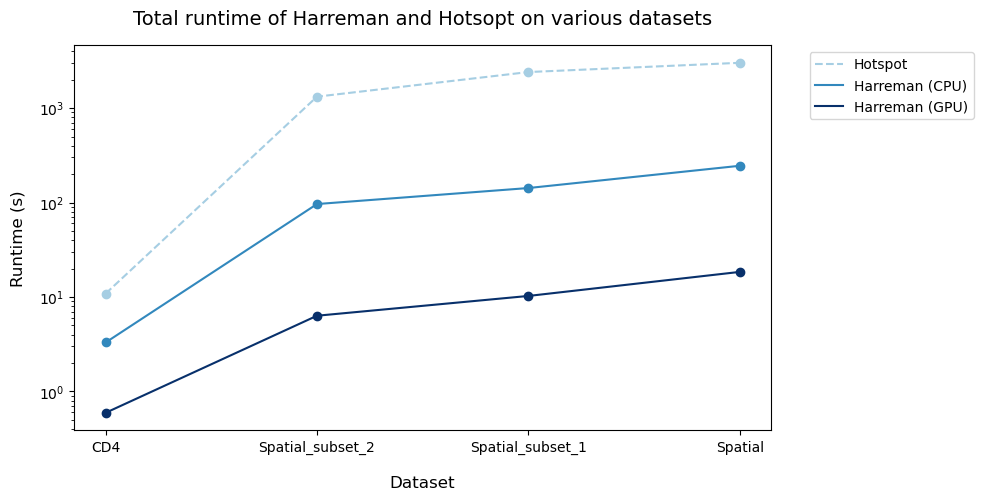

In [ ]:
fig, ax = plt.subplots(figsize=(9,5))

x_positions = np.arange(len(datasets)) - 0.25
idx = 0

for i, method in enumerate(methods):
    runtime = runtime_dict[method]
    linestyle = 'dashed' if method == 'Hotspot' else 'solid'
    ax.plot(np.arange(len(runtime.keys())), list(runtime.values()), label=method, color=colors[i], linestyle=linestyle)
    ax.scatter(np.arange(len(runtime.keys())), list(runtime.values()), color=colors[i])
    idx += 1

ax.set_xticks(np.arange(len(datasets)), datasets)
ax.set_xlabel('Dataset', fontsize=12, labelpad=15)
ax.set_ylabel('Runtime (s)', fontsize=12, labelpad=10)
ax.set_title('Total runtime of Harreman and Hotsopt on various datasets', fontsize=14, pad=15)

ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
ax.set_yscale('log')

plt.savefig(os.path.join(PLOTS_PATH, 'Harreman_Hotspot_runtime.svg'), bbox_inches='tight')
plt.show()

### Different number of genes

In [ ]:
with open(os.path.join(DATA_PATH, 'Hotspot_runtime_n_genes_dict.pkl'), 'rb') as f:
    hs_runtime_dict = pickle.load(f)

with open(os.path.join(DATA_PATH, 'Harreman_runtime_n_genes_dict.pkl'), 'rb') as f:
    runtime_dict = pickle.load(f)

In [ ]:
runtime_dict['Hotspot'] = hs_runtime_dict['Hotspot']

In [ ]:
runtime_dict

{'Harreman (CPU)': {200: 219.60160541534424,
  400: 236.41552329063416,
  600: 246.36112117767334,
  800: 261.7568600177765},
 'Harreman (GPU)': {200: 16.37363600730896,
  400: 16.12171173095703,
  600: 17.912604808807373,
  800: 18.110294103622437},
 'Hotspot': {200: 797.8856191635132,
  400: 2399.4920637607574,
  600: 4494.38166475296,
  800: 6993.753687143326}}

In [ ]:
runtime_df = pd.DataFrame.from_dict(runtime_dict).reset_index().rename(columns={'index': 'Number of genes'})
runtime_melt_df = pd.melt(runtime_df, id_vars=['Number of genes'], value_vars=['Harreman (CPU)', 'Harreman (GPU)', 'Hotspot']).rename(columns={'variable': 'Method', 'value': 'Runtime (s)'}).dropna()

In [ ]:
n_genes = [200, 400, 600, 800]
methods = ['Hotspot', 'Harreman (CPU)', 'Harreman (GPU)']

In [ ]:
runtime_melt_df.Method = runtime_melt_df.Method.astype('category')
runtime_melt_df.Method = runtime_melt_df.Method.cat.reorder_categories(methods)

runtime_melt_df['Number of genes'] = runtime_melt_df['Number of genes'].astype('category')
runtime_melt_df['Number of genes'] = runtime_melt_df['Number of genes'].cat.reorder_categories(n_genes)

In [ ]:
colors = ['#A6CEE3', '#3288BD', "#08306B"]

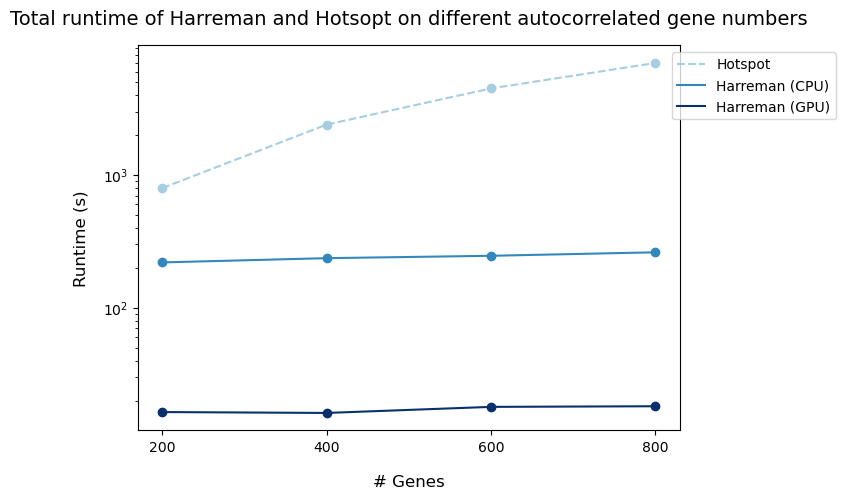

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))

x_positions = np.arange(len(n_genes)) - 0.25
idx = 0

for i, method in enumerate(methods):
    runtime = runtime_dict[method]
    linestyle = 'dashed' if method == 'Hotspot' else 'solid'
    ax.plot(np.arange(len(runtime.keys())), list(runtime.values()), label=method, color=colors[i], linestyle=linestyle)
    ax.scatter(np.arange(len(runtime.keys())), list(runtime.values()), color=colors[i])
    idx += 1

ax.set_xticks(np.arange(len(n_genes)), n_genes)
ax.set_xlabel('# Genes', fontsize=12, labelpad=15)
ax.set_ylabel('Runtime (s)', fontsize=12, labelpad=10)
ax.set_title('Total runtime of Harreman and Hotsopt on different autocorrelated gene numbers', fontsize=14, pad=15)

ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
ax.set_yscale('log')

plt.savefig(os.path.join(PLOTS_PATH, 'Harreman_Hotspot_n_genes_runtime.svg'), bbox_inches='tight')
plt.show()